In [59]:
import pandas as pd 
import numpy as np 
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier 
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pylab as plt
from matplotlib import pyplot
%matplotlib inline

In [45]:
dataset = pd.read_csv("train_final.csv")
test_dataset = pd.read_csv("test_final.csv")

In [62]:
# feature_cols = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20','f21','f22','f23','f24']
feature_cols = ['f1','f3','f4','f7','f8','f10','f12','f13','f14','f15','f16','f17','f19','f23',]
# remove_feature_cols = ['f2','f5','f6','f9','f11','f18','f20','f21','f22','f24']
features_X = dataset[feature_cols]
target = 'Y'
IDcol = 'Id'
target_Y = dataset['Y']
test_feature = test_dataset[feature_cols]
test_Id = test_dataset['Id']
predictors = [x for x in features_X.columns if x not in [target,IDcol]]


In [76]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( 
    learning_rate =0.1, 
    n_estimators=140, 
    max_depth=5,
    min_child_weight=1, 
    gamma=0, 
    subsample=0.8, 
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=8, 
    scale_pos_weight=1, 
    seed=42
), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(dataset[predictors],dataset['Y'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

KeyboardInterrupt: 

In [ ]:
param_test2 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( 
    learning_rate =0.1, 
    n_estimators=140, 
    max_depth=8,
    min_child_weight=1, 
    gamma=0, 
    subsample=0.8, 
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=8, 
    scale_pos_weight=1, 
    seed=42
), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(dataset[predictors],dataset['Y'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [13]:
param_test3 = {
    'subsample':[i/100.0 for i in range(65,90,5)],
    'colsample_bytree':[i/100.0 for i in range(65,90,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( 
    learning_rate =0.1, 
    n_estimators=140, 
    max_depth=8,
    min_child_weight=1, 
    gamma=0, 
    subsample=0.8, 
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=8, 
    scale_pos_weight=1, 
    seed=42
), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(dataset[predictors],dataset['Y'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are acc

({'mean_fit_time': array([4.89152122, 3.85928359, 3.76613264, 3.79505544, 3.69911141,
         3.98634386, 7.07947683, 7.3104589 , 5.62636037, 4.83667083,
         5.05269332, 4.80974345, 4.47384143, 4.50914607, 4.41439977,
         4.62882652, 4.78820086, 4.83128514, 5.76897864, 5.67423182,
         5.66485739, 5.37064309, 5.61878152, 5.27130876, 4.30449347]),
  'std_fit_time': array([0.42524763, 0.06185018, 0.07705783, 0.0387262 , 0.04633086,
         0.05287547, 2.54000068, 1.04667749, 0.30384391, 0.10824587,
         0.10437143, 0.15744831, 0.08020779, 0.04910823, 0.03589493,
         0.05603688, 0.04690666, 0.18980247, 0.4718508 , 0.19081863,
         0.15444873, 0.15522703, 0.21293785, 0.32687818, 0.98383327]),
  'mean_score_time': array([0.02433496, 0.02154236, 0.02234035, 0.02094412, 0.02114391,
         0.02214155, 0.03191447, 0.02932124, 0.02632961, 0.02413545,
         0.01954794, 0.01695433, 0.01615686, 0.01855068, 0.01695509,
         0.0185503 , 0.0185504 , 0.01835122, 0.

In [17]:
param_test4 = {
    'reg_alpha':[1e-9, 1e-8, 1e-7,1e-6, 1e-5, 1e-4,1e-3]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( 
    learning_rate =0.1, 
    n_estimators=140, 
    max_depth=8,
    min_child_weight=1, 
    gamma=0, 
    subsample=0.7, 
    colsample_bytree=0.7,
    objective= 'binary:logistic', 
    nthread=8, 
    scale_pos_weight=1, 
    seed=42
), 
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(dataset[predictors],dataset['Y'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are acc

({'mean_fit_time': array([3.9897275 , 3.9963172 , 4.06712747, 4.01865773, 4.01626334,
         4.27118216, 3.67597461]),
  'std_fit_time': array([0.05161002, 0.03082431, 0.05906026, 0.08562412, 0.03464632,
         0.25418425, 0.61032198]),
  'mean_score_time': array([0.03211474, 0.02473397, 0.0359046 , 0.01894903, 0.02253976,
         0.01954951, 0.02612634]),
  'std_score_time': array([0.01796743, 0.0087493 , 0.0103644 , 0.0054627 , 0.01002469,
         0.00264377, 0.01147821]),
  'param_reg_alpha': masked_array(data=[1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-09},
   {'reg_alpha': 1e-08},
   {'reg_alpha': 1e-07},
   {'reg_alpha': 1e-06},
   {'reg_alpha': 1e-05},
   {'reg_alpha': 0.0001},
   {'reg_alpha': 0.001}],
  'split0_test_score': array([0.87310623, 0.87310623, 0.87310623, 0.87310623, 0.87310623,
         0.86841082, 

In [40]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Y'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Y'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Y'], dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore())
#     feat_imp.sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9933
AUC Score (Train): 0.999945


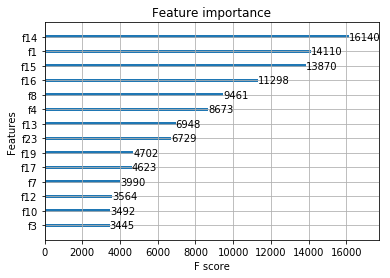

In [ ]:
# X_train,X_test,y_train,y_test=train_test_split(features_X,target_Y,test_size=0.25,random_state=42)

# logreg = LogisticRegression()

# logreg.fit(X_train, y_train)

# y_pred = logreg.predict(X_test)

model = XGBClassifier(
    learning_rate =0.01, 
    n_estimators=5000, 
    max_depth=8,
    min_child_weight=1, 
    gamma=0, 
    subsample=0.7, 
    colsample_bytree=0.7,
    objective= 'binary:logistic', 
    nthread=8, 
    scale_pos_weight=1, 
    seed=42,
    reg_alpha = 1e-7
)

# model_forest = RandomForestClassifier()
# model_forest.fit(predictors, target_Y)


modelfit(model,dataset,predictors)






plot_importance(model)
pyplot.show()
kfold = KFold(n_splits=10, random_state=42)
results = cross_val_score(model, features_X, target_Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



In [54]:
submitModelPredict = model.predict_proba(test_feature)
submission = pd.DataFrame({'Id': test_Id, 'Y':submitModelPredict[:,1]})
submission.head()

,Id,Y
0,16384,0.914322
1,16385,0.953765
2,16386,0.999812
3,16387,0.999642
4,16388,0.991376


In [55]:
filename = 'submit.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: submit.csv
